In [1]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import numpy as np

In [2]:
# 1. Data Collection (API)

URL = 'http://apis.data.go.kr/1160100/GetAutoInsVicInfoService/getAutoInsVicMonthInfo'
SERVICE_KEY = 'bee5136b7a7e24a1198a6692d0fedc9f40b427286fe3721768b6d6ee33fab2a6'

def fetch_accident_data(start_ym, end_ym):
    all_data = []
    start_date = pd.to_datetime(str(start_ym), format='%Y%m')
    end_date = pd.to_datetime(str(end_ym), format='%Y%m')
    target_months = pd.date_range(start=start_date, end=end_date, freq='MS').strftime("%Y%m").tolist()

    print(f"Collecting Data: {target_months[0]} ~ {target_months[-1]}...")

    for month in target_months:
        params = {
            'serviceKey': requests.utils.unquote(SERVICE_KEY),
            'pageNo': '1', 'numOfRows': '1000', 'resultType': 'json', 'basYm': month
        }
        try:
            response = requests.get(URL, params=params)
            if response.status_code == 200:
                items = response.json()['response']['body']['items']['item']
                if isinstance(items, dict): items = [items]
                all_data.extend(items)
        except Exception:
            continue

    return pd.DataFrame(all_data)

df_raw = fetch_accident_data(202401, 202406)
df_raw.to_csv('[기데분프로젝트]김예진.csv', index=False, encoding='utf-8-sig')

In [3]:
# 2. Advanced Preprocessing

df = df_raw.copy()
df.columns = ['YearMonth', 'Type', 'Disability', 'InjuryGrade', 'DisabilityGrade', 'Count', 'AvgInsurance']

# 수치형 변환
df['Count'] = pd.to_numeric(df['Count'], errors='coerce')
df['AvgInsurance'] = pd.to_numeric(df['AvgInsurance'], errors='coerce')
df['InjuryGrade'] = pd.to_numeric(df['InjuryGrade'], errors='coerce') # 상관분석을 위해 숫자로 변환
df['Disability'] = pd.to_numeric(df['Disability'], errors='coerce')

# ID 생성
df['ID'] = df['YearMonth'].astype(str) + "_" + df['InjuryGrade'].astype(str) + "_" + df['DisabilityGrade'].astype(str)
df.drop_duplicates(subset=['ID'], keep='first', inplace=True)
df.dropna(inplace=True)

print(f"분석 대상 데이터 수: {len(df)}건")

분석 대상 데이터 수: 619건


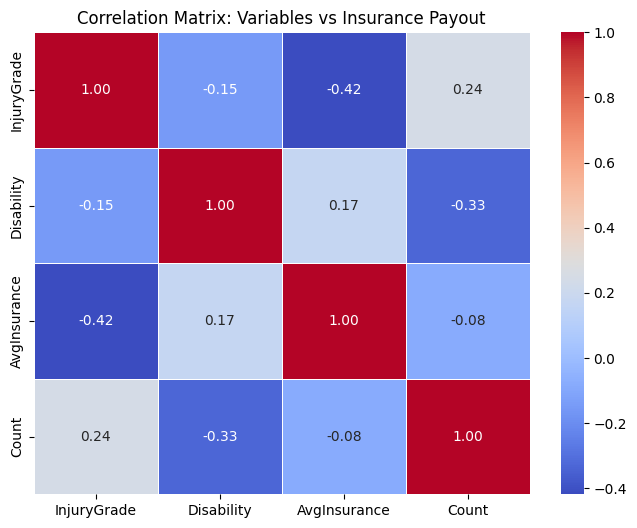


[T-Test Result]
T-statistic: 10.0628
P-value: 2.9571e-20


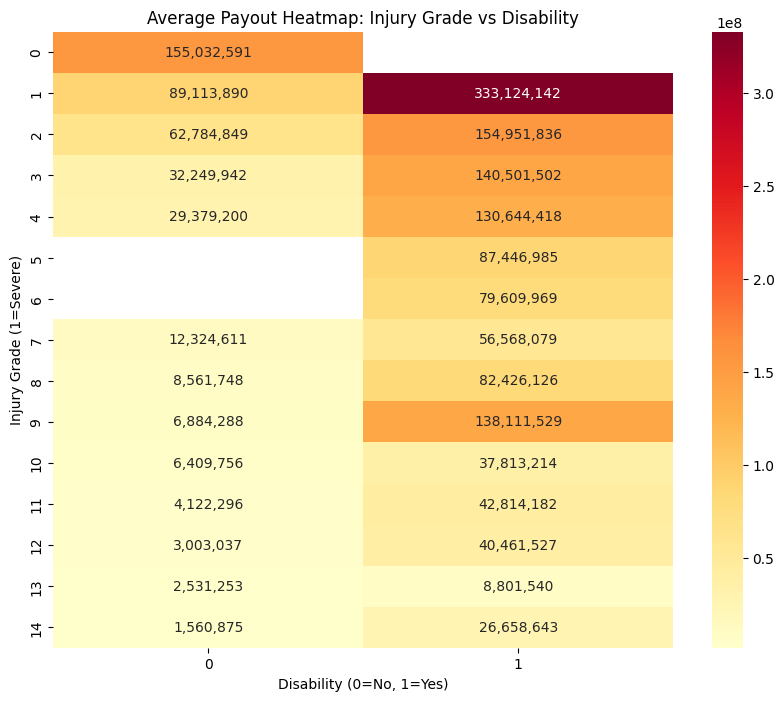

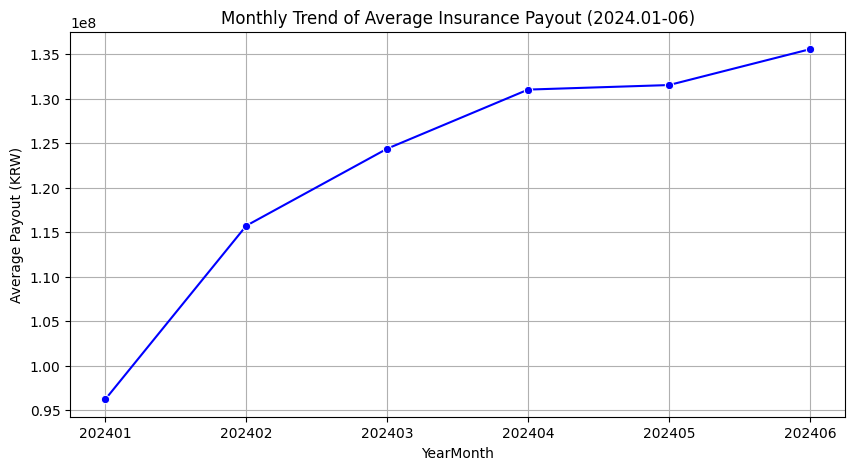

In [4]:
# 3. Deep Analysis & Visualization

plt.rcParams['font.family'] = 'sans-serif'

# [Analysis 1] 상관관계 히트맵 (Correlation Heatmap)
# 목표: 부상 급수(숫자)와 보험금 간의 '음의 상관관계' 증명
plt.figure(figsize=(8, 6))
# 상관계수 계산 대상 컬럼
corr_df = df[['InjuryGrade', 'Disability', 'AvgInsurance', 'Count']]
corr_matrix = corr_df.corr()

sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix: Variables vs Insurance Payout')
plt.show()
# 해석: InjuryGrade와 AvgInsurance의 계수가 음수(-)라면, 급수 숫자가 작을수록 보험금이 높다는 뜻.


# [Analysis 2] 통계적 가설 검정 (T-test)
# 가설: "장애가 있는 그룹의 보험금 평균은 장애가 없는 그룹과 통계적으로 유의미하게 다른가?"
group_disability = df[df['Disability'] == 1]['AvgInsurance']
group_normal = df[df['Disability'] == 0]['AvgInsurance']

t_stat, p_val = stats.ttest_ind(group_disability, group_normal, equal_var=False)

print("\n[T-Test Result]")
print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_val:.4e}")  # P-value < 0.05 이면 유의미한 차이


# [Analysis 3] 복합 세그먼트 시각화 (Pivot Heatmap)
# 목표: 부상급수 X 장애여부 교차 분석
pivot_table = df.pivot_table(index='InjuryGrade', columns='Disability', values='AvgInsurance', aggfunc='mean')

plt.figure(figsize=(10, 8))
sns.heatmap(pivot_table, annot=True, fmt=',.0f', cmap='YlOrRd')
plt.title('Average Payout Heatmap: Injury Grade vs Disability')
plt.ylabel('Injury Grade (1=Severe)')
plt.xlabel('Disability (0=No, 1=Yes)')
plt.show()


# [Analysis 4] 시계열 추세 (Time Series Trend)
# 목표: 월별 보험금 지급 총액 추이
monthly_trend = df.groupby('YearMonth')['AvgInsurance'].mean().reset_index()

plt.figure(figsize=(10, 5))
sns.lineplot(data=monthly_trend, x='YearMonth', y='AvgInsurance', marker='o', color='b')
plt.title('Monthly Trend of Average Insurance Payout (2024.01-06)')
plt.ylabel('Average Payout (KRW)')
plt.grid(True)
plt.show()